# CS 480/680 assignment 4

Tips:
- Please save a copy of this notebook to avoid losing your changes.
- Debug your code and ensure that it can run.
- Save the output of each cell. Failure to do so may result in your coding questions not being graded.
- To accelerate the training time, you can choose 'Runtime' -> 'Change runtime type' -> 'Hardware accelerator' and set 'Hardware accelerator' to 'GPU'.
- Your grade is independent of the accuracy of your models. Your grade will depend on the correctness of your code and implementation.

Tips for submission:
- Do not change the order of the problems.
- Select 'Runtime' -> 'Run all' to run all cells and generate a final "gradable" version of your notebook and save your ipynb file.
- Also use 'File' -> 'Print' and then print your report from your browser into a PDF file.

##Question1 - Adversarial Training (55 points)

In this assignment, you are supposed to train a model using limited data that, in addition to generalization, also possesses good robustness.


You can add any extra libraries that you need in this cell.

In [10]:
import torch
import torchvision
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import transforms
from collections import Counter
import matplotlib.pyplot as plt
import torchvision.models as models
import umap
from tqdm import tqdm
import torch.nn as nn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import random
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method

In [11]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
SEED = 1

###Q1.1 Load Data (5 points)

In this question, you are going to use CIFAR-10 dataset. First, load this dataset, then split 20% of the data for training and the rest for validation. Make sure to maintain class balance during the split.

In [13]:
Train_SIZE = 0.2
cifar_transforms = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
cifar_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
cifar_testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [14]:
class Cifar10Dataset(torch.utils.data.Dataset):

    def __init__(self,dataset,idx,transforms=None):
        self.idx = idx
        self.transforms = transforms
        self.data = torch.utils.data.Subset(dataset, idx)

    def __getitem__(self,index):
        image,label = self.data[index]
        if(self.transforms!= None):
            image = self.transforms(image)

        return image,label

    def __len__(self):
        return len(self.data)

In [15]:
# Split data into train, validation, and test datasets

# use stratify=cifar_trainset.targets to maintain class balance
train_labels,val_labels = train_test_split(np.arange(len(cifar_trainset)), 
                                           train_size=Train_SIZE, 
                                           random_state=SEED, 
                                           stratify=cifar_trainset.targets)
test_labels = np.arange(len(cifar_testset))

train_data = Cifar10Dataset(cifar_trainset, train_labels, cifar_transforms)
val_data = Cifar10Dataset(cifar_trainset, val_labels, cifar_transforms)
test_data = Cifar10Dataset(cifar_testset, test_labels, cifar_transforms)

In [16]:
print('Train Data Size:', len(train_data))
print('Validation Data Size:', len(val_data))
print('Test Data Size:', len(test_data))

Train Data Size: 10000
Validation Data Size: 40000
Test Data Size: 10000


In [17]:
# Create dataloaders
batch_size = 50
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [18]:
def class_hist(dataset):
    print('Total Datapoints:', len(dataset))
    arr = np.array([i[1] for i in dataset])
    plt.hist(arr)
    plt.title('Dataset Class Balance')
    plt.xlabel('Class')
    plt.ylabel('Number of Datapoints')
    plt.show()

Total Datapoints: 50000


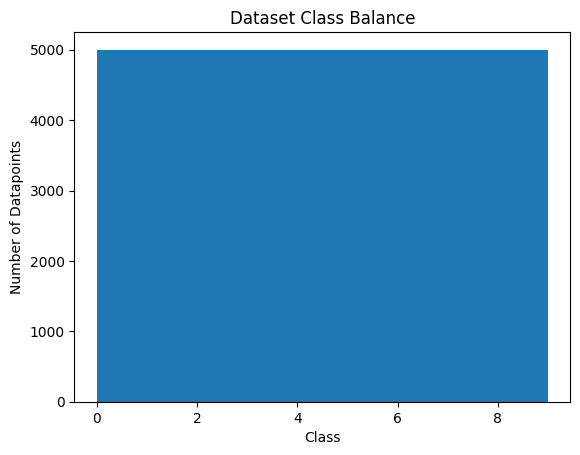

In [19]:
class_hist(cifar_trainset)

Total Datapoints: 10000


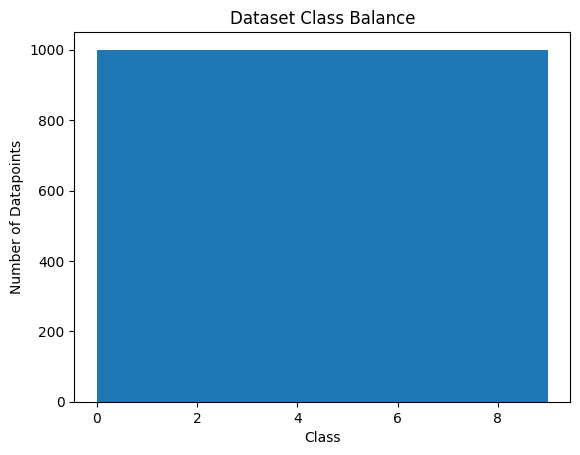

In [20]:
class_hist(train_data.data)

We see from the above histograms that the splitting maintained class balance!

###Q1.2 Train Model (15 points)

Train a ResNet18 model using the cross-entropy loss function, and report its accuracy on validation and test datasets.

After that, reduce the dimensionality of the output of the backbone of the network and visualize it for the unseen data. You can use UMAP for dimensionality reduction. Note that for this task, you are not allowed to use the labels.

In [21]:
class Resnet18(nn.Module):
    def __init__(self, num_classes,normalize = False):
        super().__init__()
        self.backbone = models.resnet18(weights='DEFAULT')
        self.backbone.fc = nn.Identity()
        self.backbone.to(device)
        self.head = nn.Linear(512, num_classes)
        self.head.to(device)

    def forward(self, x):
        x = self.backbone(x)
        x = self.head(x)
        return x

In [22]:
def train(model,data_loader,criterion,optimizer,attack=False):

    running_loss = 0.
    running_steps = 0
    n_correct = 0
    n_total = 0

    with tqdm(data_loader, desc ="   train") as train_tqdm:
        for batch_idx, (inputs, targets) in enumerate(train_tqdm):
            model.train() # add a call before calling train function
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_steps += 1

            _, pred = torch.max(outputs, 1)
            n_correct += (pred==targets).sum().item()
            n_total += len(targets)
    
    average_train_loss = running_loss / running_steps
    accuracy = n_correct / n_total * 100.

    return average_train_loss, accuracy

In [23]:
@torch.no_grad()
def test(model,data_loader,criterion,optimizer,attack=False):
    model.eval()

    running_loss = 0.
    running_steps = 0
    n_correct = 0
    n_total = 0

    with tqdm(data_loader, desc ="   test") as test_tqdm:
        for batch_idx, (inputs, targets) in enumerate(test_tqdm):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, targets)
            running_loss += loss.item()
            running_steps += 1

            _, pred = torch.max(outputs, 1)
            n_correct += (pred==targets).sum().item()
            n_total += len(targets)
    
    average_test_loss = running_loss / running_steps
    accuracy = n_correct / n_total * 100.0

    return average_test_loss, accuracy

In [24]:
model = Resnet18(num_classes=10)
lr = 0.008
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [25]:
for i in range(100):
    train_avg_loss, train_accuracy = train(model, train_loader, criterion, optimizer)
    if (i+1)%10 == 0:
        val_avg_loss, val_accuracy = test(model, val_loader, criterion, optimizer)
        print('Epoch: {:3d}, Train Average Loss: {:.2f}, Train Accuracy: {:.1f}%, Validation Average Loss: {:.2f}, Validation Accuracy: {:.1f}%'\
              .format(i+1, train_avg_loss, train_accuracy, val_avg_loss, val_accuracy))

   test: 100%|██████████| 800/800 [00:11<00:00, 67.05it/s]


Epoch:  10, Train Average Loss: 1.18, Train Accuracy: 57.3%, Validation Average Loss: 1.26, Validation Accuracy: 55.2%


   test: 100%|██████████| 800/800 [00:11<00:00, 69.91it/s]


Epoch:  20, Train Average Loss: 0.38, Train Accuracy: 86.4%, Validation Average Loss: 1.53, Validation Accuracy: 60.1%


   test: 100%|██████████| 800/800 [00:11<00:00, 71.40it/s]


Epoch:  30, Train Average Loss: 0.13, Train Accuracy: 95.5%, Validation Average Loss: 1.90, Validation Accuracy: 62.8%


   test: 100%|██████████| 800/800 [00:11<00:00, 70.24it/s]


Epoch:  40, Train Average Loss: 0.08, Train Accuracy: 97.4%, Validation Average Loss: 2.18, Validation Accuracy: 61.5%


   test: 100%|██████████| 800/800 [00:11<00:00, 69.92it/s]


Epoch:  50, Train Average Loss: 0.07, Train Accuracy: 97.8%, Validation Average Loss: 2.33, Validation Accuracy: 61.8%


   test: 100%|██████████| 800/800 [00:11<00:00, 70.67it/s]


Epoch:  60, Train Average Loss: 0.06, Train Accuracy: 98.2%, Validation Average Loss: 2.37, Validation Accuracy: 61.8%


   test: 100%|██████████| 800/800 [00:11<00:00, 72.09it/s]


Epoch:  70, Train Average Loss: 0.05, Train Accuracy: 98.4%, Validation Average Loss: 2.56, Validation Accuracy: 61.1%


   test: 100%|██████████| 800/800 [00:11<00:00, 71.44it/s]


Epoch:  80, Train Average Loss: 0.06, Train Accuracy: 98.1%, Validation Average Loss: 2.58, Validation Accuracy: 61.7%


   test: 100%|██████████| 800/800 [00:11<00:00, 71.34it/s]


Epoch:  90, Train Average Loss: 0.05, Train Accuracy: 98.3%, Validation Average Loss: 2.55, Validation Accuracy: 61.0%


   test: 100%|██████████| 800/800 [00:11<00:00, 71.48it/s]

Epoch: 100, Train Average Loss: 0.05, Train Accuracy: 98.5%, Validation Average Loss: 2.62, Validation Accuracy: 61.4%


We see that validation accuracy stopped increasing around Epoch 30 -- we could have stopped the training at around that point; the rest of the training improved train accuracy but not validation accuracy, i.e. the model was overfitting. I chose to keep this classifier anyways because it still performs reasonably well on the validation and test data.

In [26]:
val_avg_loss, val_accuracy = test(model, val_loader, criterion, optimizer)
test_avg_loss, test_accuracy = test(model, test_loader, criterion, optimizer)

print('Q1.2: Non-Adversarially Trained Model; Non-Adversarial Test Set')
print('Validation Average Loss: {:.2f}'.format(val_avg_loss))
print('Validation Accuracy: {:.1f}%'.format(val_accuracy))
print('Test Average Loss: {:.2f}'.format(test_avg_loss))
print('Test Accuracy: {:.1f}%'.format(test_accuracy))

   test: 100%|██████████| 200/200 [00:02<00:00, 72.26it/s]

Q1.2: Non-Adversarially Trained Model; Non-Adversarial Test Set
Validation Average Loss: 2.62
Validation Accuracy: 61.4%
Test Average Loss: 2.64
Test Accuracy: 61.5%


In [27]:
def plot_umap(features, y):
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(features)
    plt.scatter(embedding[:,0], embedding[:,1], c=y, cmap='Spectral', s=0.1)
    plt.gca().set_aspect('equal', 'datalim')
    plt.colorbar().set_label('Labels')
    plt.show()

In [28]:
@torch.no_grad()
def get_features(model, data_loader):
    model.eval()
    outputs_lst = []
    targets_lst = []

    for inputs, targets in data_loader:
        inputs = inputs.to(device)
        outputs = model.backbone(inputs)
        outputs_lst.append(outputs.cpu())
        targets_lst.append(targets.cpu())

    features = torch.cat(outputs_lst, 0)  # Output of backbone of trained model
    labels = torch.cat(targets_lst, 0)    # True labels

    return features, labels

Q1.2: Non-Adversarially Trained Model; Non-Adversarial Test Set


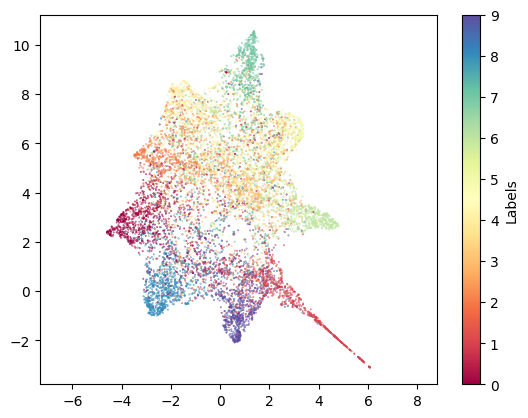

In [29]:
features, y_test = get_features(model, test_loader)
print('Q1.2: Non-Adversarially Trained Model; Non-Adversarial Test Set')
plot_umap(features, y_test)

We see that the labels are clustered fairly well in the UMap above!

###Q1.3 Adversarial Test (15 points)


In this section, you are required to change the unseen data before calculating the accuracy of them from the output image of the backbone. Compare the results with the previous section. Your changes should include data augmentations such as adding Gaussian noise, color jitter, etc. Additionally, you should apply an adversarial attack such as fast gradient method on the network. You can use the cleverhans library for this purpose.

In [30]:
augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomPerspective(),
    transforms.ColorJitter(),
    transforms.GaussianBlur(3)])

In [31]:
aug_transforms = transforms.Compose([cifar_transforms, augmentation])

test_data_aug = Cifar10Dataset(cifar_testset, test_labels, aug_transforms)
test_loader_aug = torch.utils.data.DataLoader(test_data_aug, batch_size=batch_size, shuffle=True)

In [32]:
def generate_fgm_examples(model,data_loader,criterion,eps=0.1):
    adv_inputs_lst = []
    targets_lst = []

    model.eval()
    with tqdm(data_loader) as test_tqdm:
        for batch_idx, (inputs, targets) in enumerate(test_tqdm):
            inputs, targets = inputs.to(device), targets.to(device)
            adv_inputs = fast_gradient_method(model, inputs, eps, np.inf)
            adv_inputs_lst.append(adv_inputs.detach().cpu())
            targets_lst.append(targets.detach().cpu())

    examples = torch.cat(adv_inputs_lst, 0)
    labels = torch.cat(targets_lst, 0)

    return examples,labels

In this assignment I take the approach of generating adversarial inputs on the trained (i.e most recent) version of the model.

In [33]:
test_examples_adv,test_labels_adv = generate_fgm_examples(model, test_loader_aug, criterion)

100%|██████████| 200/200 [00:15<00:00, 12.77it/s]


Q1.3: Non-Adversarially Trained Model; Adversarial Test Set


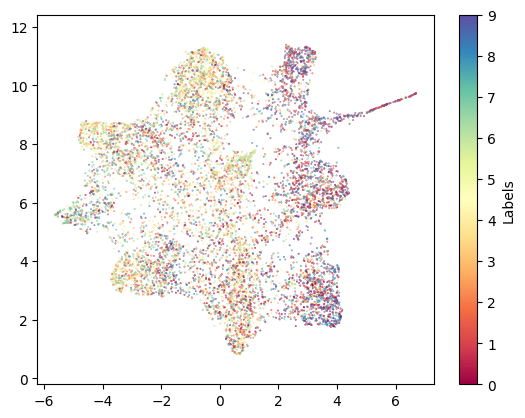

In [57]:
test_dataset_adv = torch.utils.data.TensorDataset(test_examples_adv, test_labels_adv)
test_loader_adv = torch.utils.data.DataLoader(test_dataset_adv, batch_size=batch_size, shuffle=True)
advx_test,advy_test = get_features(model, test_loader_adv)
print('Q1.3: Non-Adversarially Trained Model; Adversarial Test Set')
plot_umap(advx_test,advy_test)

We see that the labels are clustered very poorly and the test accuracy is low on the adversarial test set.

In [35]:
test_avg_loss, test_accuracy = test(model, test_loader_adv, criterion, optimizer)

print('Q1.3: Non-Adversarially Trained Model; Adversarial Test Set')
print('Test Average Loss: {:.2f}'.format(test_avg_loss))
print('Test Accuracy: {:.1f}%'.format(test_accuracy))

   test: 100%|██████████| 200/200 [00:01<00:00, 167.07it/s]

Q1.3: Non-Adversarially Trained Model; Adversarial Test Set
Test Average Loss: 12.02
Test Accuracy: 20.3%


##Q1.4 Adversarial Train (20 points)


In this section, you should repeat the experiments on parts two and three using adversarial examples and compare the results. Here, the training data will be modified using augmentations and adversarial attack.

In [36]:
val_data_aug = Cifar10Dataset(cifar_trainset, val_labels, aug_transforms)
train_data_aug = Cifar10Dataset(cifar_trainset, train_labels, aug_transforms)
val_loader_aug = torch.utils.data.DataLoader(val_data_aug, batch_size=batch_size, shuffle=True)
train_loader_aug = torch.utils.data.DataLoader(train_data_aug, batch_size=batch_size, shuffle=True)

In [37]:
#Train resnet18 using the adversarial examples

def train_adv(model, data_loader, criterion, optimizer, eps=0.1):

    running_loss = 0.
    running_steps = 0
    n_correct = 0
    n_total = 0

    with tqdm(data_loader, desc ="   train") as train_tqdm:
        for batch_idx, (inputs, targets) in enumerate(train_tqdm):
            model.train()
            inputs, targets = inputs.to(device), targets.to(device)
            # Generate new adversarial data while training (based on the current model)
            inputs_fgm = fast_gradient_method(model, inputs, eps, np.inf)

            optimizer.zero_grad()
            outputs = model(inputs_fgm)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_steps += 1

            _, pred = torch.max(outputs, 1)
            n_correct += (pred==targets).sum().item()
            n_total += len(targets)
    
    average_train_loss = running_loss / running_steps
    accuracy = n_correct / n_total * 100.

    return average_train_loss, accuracy

In [38]:
model_adv = Resnet18(num_classes=10)
optimizer_adv = torch.optim.Adam(model_adv.parameters(), lr=lr)

In [39]:
for i in range(100):
    train_avg_loss, train_accuracy = train_adv(model_adv, train_loader_aug, criterion, optimizer_adv)

    if (i+1)%10 == 0:
        # Generate adversarial validation data based on the current state of the model        
        val_examples_adv,val_labels_adv = generate_fgm_examples(model_adv, val_loader_aug, criterion)
        val_dataset_adv = torch.utils.data.TensorDataset(val_examples_adv, val_labels_adv)
        val_loader_adv = torch.utils.data.DataLoader(val_dataset_adv, batch_size=batch_size, shuffle=True)
        val_avg_loss, val_accuracy = test(model_adv, val_loader_adv, criterion, optimizer_adv)

        print('Epoch: {:3d}, Train Average Loss: {:.2f}, Train Accuracy: {:.1f}%, Validation Average Loss: {:.2f}, Validation Accuracy: {:.1f}%'\
              .format(i+1, train_avg_loss, train_accuracy, val_avg_loss, val_accuracy))

   test: 100%|██████████| 800/800 [00:04<00:00, 183.62it/s]


Epoch:  10, Train Average Loss: 1.88, Train Accuracy: 27.1%, Validation Average Loss: 2.35, Validation Accuracy: 26.4%


   test: 100%|██████████| 800/800 [00:04<00:00, 191.10it/s]


Epoch:  20, Train Average Loss: 1.77, Train Accuracy: 30.7%, Validation Average Loss: 1.83, Validation Accuracy: 29.1%


   test: 100%|██████████| 800/800 [00:04<00:00, 194.03it/s]


Epoch:  30, Train Average Loss: 1.72, Train Accuracy: 31.9%, Validation Average Loss: 1.80, Validation Accuracy: 30.8%


   test: 100%|██████████| 800/800 [00:04<00:00, 197.69it/s]


Epoch:  40, Train Average Loss: 1.67, Train Accuracy: 33.1%, Validation Average Loss: 1.80, Validation Accuracy: 29.2%


   test: 100%|██████████| 800/800 [00:04<00:00, 192.62it/s]


Epoch:  50, Train Average Loss: 1.63, Train Accuracy: 35.1%, Validation Average Loss: 1.78, Validation Accuracy: 30.2%


   test: 100%|██████████| 800/800 [00:04<00:00, 189.62it/s]


Epoch:  60, Train Average Loss: 1.58, Train Accuracy: 35.4%, Validation Average Loss: 1.76, Validation Accuracy: 30.8%


   test: 100%|██████████| 800/800 [00:03<00:00, 203.01it/s]


Epoch:  70, Train Average Loss: 1.55, Train Accuracy: 36.6%, Validation Average Loss: 1.85, Validation Accuracy: 30.0%


   test: 100%|██████████| 800/800 [00:03<00:00, 200.91it/s]


Epoch:  80, Train Average Loss: 1.53, Train Accuracy: 37.2%, Validation Average Loss: 1.80, Validation Accuracy: 29.7%


   test: 100%|██████████| 800/800 [00:03<00:00, 202.33it/s]


Epoch:  90, Train Average Loss: 1.52, Train Accuracy: 37.4%, Validation Average Loss: 1.77, Validation Accuracy: 30.7%


   test: 100%|██████████| 800/800 [00:03<00:00, 207.69it/s]

Epoch: 100, Train Average Loss: 1.48, Train Accuracy: 39.1%, Validation Average Loss: 1.75, Validation Accuracy: 31.3%


Adversarially Trained Model; Non-Adversarial Test Set


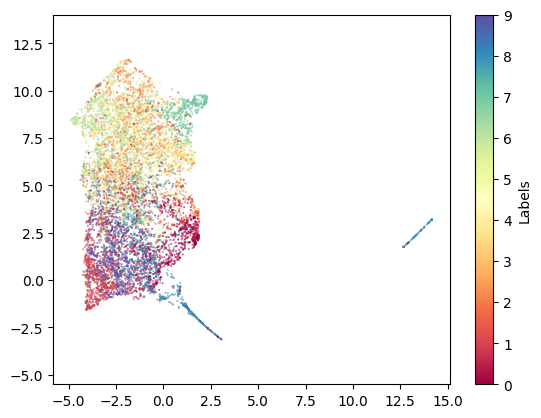

In [59]:
features_adv, y_test = get_features(model_adv, test_loader)
print('Adversarially Trained Model; Non-Adversarial Test Set')
plot_umap(features_adv, y_test)

In [41]:
val_avg_loss, val_accuracy = test(model_adv, val_loader, criterion, optimizer)
test_avg_loss, test_accuracy = test(model_adv, test_loader, criterion, optimizer)

print('Q1.4a: Adversarially Trained Model; Non-Adversarial Test Set')
print('Validation Average Loss: {:.2f}'.format(val_avg_loss))
print('Validation Accuracy: {:.1f}%'.format(val_accuracy))
print('Test Average Loss: {:.2f}'.format(test_avg_loss))
print('Test Accuracy: {:.1f}%'.format(test_accuracy))

   test: 100%|██████████| 200/200 [00:02<00:00, 67.18it/s]

Q1.4a: Adversarially Trained Model; Non-Adversarial Test Set
Validation Average Loss: 1.22
Validation Accuracy: 57.2%
Test Average Loss: 1.22
Test Accuracy: 57.1%


We see that the adversarially trained model (57.1% accuracy) performs nearly as well as the non-adversarially trained model (61.5% accuracy) on the non-adversarial test set!

The UMap also shows a pretty good label clustering, although the scale is a little thrown off by the blue outliers.

In [63]:
# Generate adversarial validation examples on the final model
val_examples_adv,val_labels_adv = generate_fgm_examples(model_adv, val_loader_aug, criterion)
val_dataset_adv = torch.utils.data.TensorDataset(val_examples_adv, val_labels_adv)
val_loader_adv = torch.utils.data.DataLoader(val_dataset_adv, batch_size=batch_size, shuffle=True)

100%|██████████| 800/800 [01:02<00:00, 12.82it/s]


In [64]:
test_examples_adv,test_labels_adv = generate_fgm_examples(model_adv, test_loader_aug, criterion)
test_dataset_adv = torch.utils.data.TensorDataset(test_examples_adv, test_labels_adv)
test_loader_adv = torch.utils.data.DataLoader(test_dataset_adv, batch_size=batch_size, shuffle=True)

100%|██████████| 200/200 [00:15<00:00, 13.07it/s]


Adversarially Trained Model; Adversarial Test Set


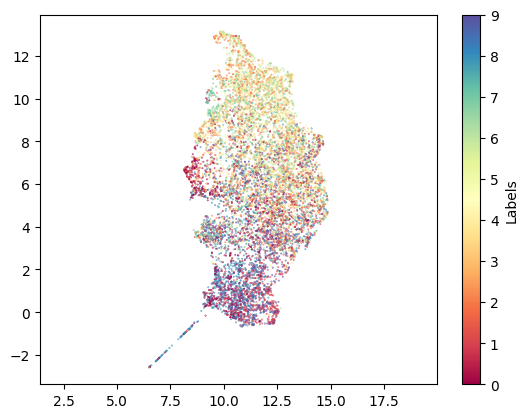

In [65]:
features_adv, advy_test = get_features(model_adv, test_loader_adv)
print('Adversarially Trained Model; Adversarial Test Set')
plot_umap(features_adv, advy_test)

In [66]:
val_avg_loss, val_accuracy = test(model_adv, val_loader_adv, criterion, optimizer)
test_avg_loss, test_accuracy = test(model_adv, test_loader_adv, criterion, optimizer)

print('Q1.4b: Adversarially Trained Model; Adversarial Test Set')
print('Validation Average Loss: {:.2f}'.format(val_avg_loss))
print('Validation Accuracy: {:.1f}%'.format(val_accuracy))
print('Test Average Loss: {:.2f}'.format(test_avg_loss))
print('Test Accuracy: {:.1f}%'.format(test_accuracy))

   test: 100%|██████████| 500/500 [00:02<00:00, 187.71it/s]

Q1.4b: Adversarially Trained Model; Adversarial Test Set
Validation Average Loss: 1.77
Validation Accuracy: 30.7%
Test Average Loss: 1.77
Test Accuracy: 31.0%


The adversarially trained model does not perform as well as hoped on the adversarial test set.

The performance is relatively poor (compared to other posts seen on Piazza) because the adversarial examples were generated based on the final trained model.

However, the adversarially trained model (31.0% accuracy) still performs notably better than the non-adversarially trained model (20.3% accuracy) on the adversarial test set. Thus, we see that the adversarial training still had benefit.

##Question2 - Diffusion Model (45 points)

This homework helps you implement a Denoising Diffusion Probabilistic Model (DDPM).  



You can add any extra libraries that you need in this cell.

In [45]:
import torchvision
from torchvision import transforms
import pandas as pd
import numpy as np
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import torch.nn as nn
from matplotlib import pyplot as plt
from PIL import Image
from keras.datasets import cifar10
from diffusers import UNet2DModel
import diffusers

device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

###Q2.1 Load Data (5 points)

In this question, you are going to use one arbitrary class of CIFAR-10 dataset. First, load this dataset, then choose any class you want and use that for the rest of this question.

In [46]:
#Load the data and choose one class, then create the data loader.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

cifar_class = 8  # ships

ships = x_train[y_train.squeeze()==cifar_class]

In [47]:
class CustomDataset(Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        if self.transform != None:
            image = self.transform(image)
        return image


preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

batch_size = 20

dataset = CustomDataset(ships, preprocess)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [48]:
def show_images(x):
    x = x * 0.5 + 0.5
    grid = torchvision.utils.make_grid(x)
    grid = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid = Image.fromarray(np.array(grid).astype(np.uint8))
    return grid

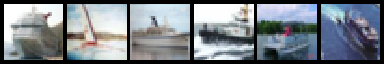

In [49]:
x_test = next(iter(dataloader))[:6]
x_test = x_test.to(device)
show_images(x_test).resize((6 * 64, 64), resample=Image.NEAREST)

###Q2.2 Forward pass (10 points)

In this section, you are going to implement the forward pass of your diffusion model. You can use diffusers library for this task. Then use show_images function to plot your target image at different times of the forward pass. (Simply use the default hypermeters mentioned in the DDPM paper or the default values of the diffuser library. Visualising images every 100 steps is enough)

Timestep: 0


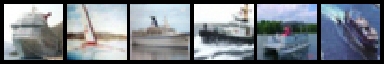

Timestep: 100


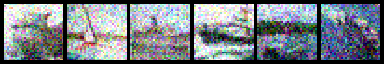

Timestep: 200


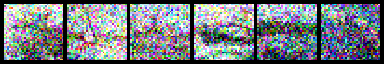

Timestep: 300


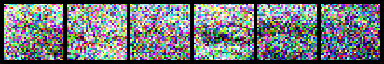

Timestep: 400


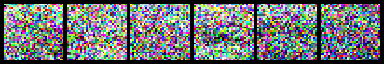

Timestep: 500


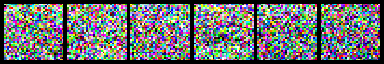

Timestep: 600


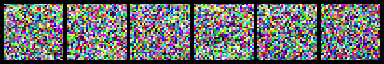

Timestep: 700


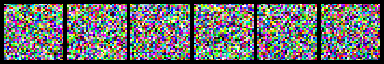

Timestep: 800


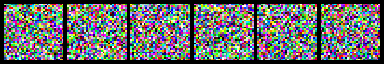

Timestep: 900


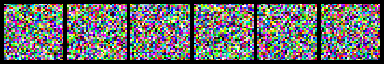

In [50]:
sched = diffusers.DDPMScheduler()
noise = torch.randn(6, 3, 32, 32).to(device)

for timestep in range(0, sched.config.num_train_timesteps, 100):
    print('Timestep:', timestep)
    timestep_arr = torch.full(([6]), timestep).to(device)
    noisy_imgs = sched.add_noise(x_test, noise, timestep_arr)
    display(show_images(noisy_imgs).resize((6 * 64, 64), resample=Image.NEAREST))

###Q2.3 Denoising (15 points)

In this section, you will implement the denoising part of your diffusion model. First, create a U-net and train it on your CIFAR10 data. Then, start from random noise and plot the denoised images of 6 random samples. (In the DDPM paper Sec 3.3, they also trained a reverse process decoder. You are not required to implement it in this assignment. Visualizing the outputs of the diffusion network is sufficient.)

In [51]:
# Fewer channels and attention layers for faster training
model_q2 = UNet2DModel(
    sample_size = 32,
    block_out_channels = (64, 128, 128, 256),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    )
)

model_q2.to(device)

sched = diffusers.DDPMScheduler()

In [52]:
def train_q2(model,data_loader,criterion,optimizer):

    running_loss = 0.
    running_steps = 0

    with tqdm(data_loader, desc ="   train") as train_tqdm:
        for batch_idx, inputs in enumerate(train_tqdm):
            model.train()
            inputs = inputs.to(device)

            optimizer.zero_grad()
            noise = torch.randn_like(inputs).to(device)
            # Random Timesteps
            timesteps = torch.randint(0, sched.config.num_train_timesteps,
                                       (batch_size,)).to(device)
            noisy_inputs = sched.add_noise(inputs, noise, timesteps)

            outputs = model(noisy_inputs, timesteps, return_dict=False)[0]
            loss = criterion(outputs, noise)
            loss.backward()
            optimizer.step()
        
            running_loss += loss.item()
            running_steps += 1

    average_train_loss = running_loss / running_steps

    return average_train_loss

In [53]:
criterion_q2 = nn.MSELoss()
optimizer_q2 = torch.optim.AdamW(model_q2.parameters(), lr=4e-4)

for epoch in range(100):
    avg_loss = train_q2(model_q2, dataloader, criterion_q2, optimizer_q2)
    if (epoch+1)%10 == 0:
        print('Epoch: {:3d}, Average Loss: {:.5f}'\
              .format(epoch+1, avg_loss))

   train: 100%|██████████| 250/250 [00:31<00:00,  8.06it/s]


Epoch:  10, Average Loss: 0.03079


   train: 100%|██████████| 250/250 [00:31<00:00,  8.01it/s]


Epoch:  20, Average Loss: 0.02865


   train: 100%|██████████| 250/250 [00:31<00:00,  8.03it/s]


Epoch:  30, Average Loss: 0.02750


   train: 100%|██████████| 250/250 [00:31<00:00,  8.06it/s]


Epoch:  40, Average Loss: 0.02813


   train: 100%|██████████| 250/250 [00:31<00:00,  8.05it/s]


Epoch:  50, Average Loss: 0.02744


   train: 100%|██████████| 250/250 [00:31<00:00,  8.06it/s]


Epoch:  60, Average Loss: 0.02633


   train: 100%|██████████| 250/250 [00:30<00:00,  8.07it/s]


Epoch:  70, Average Loss: 0.02761


   train: 100%|██████████| 250/250 [00:31<00:00,  8.05it/s]


Epoch:  80, Average Loss: 0.02712


   train: 100%|██████████| 250/250 [00:31<00:00,  8.01it/s]


Epoch:  90, Average Loss: 0.02696


   train: 100%|██████████| 250/250 [00:31<00:00,  8.04it/s]

Epoch: 100, Average Loss: 0.02644


   denoise: 1000it [00:31, 31.27it/s]


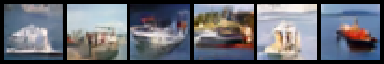

In [54]:
sample = torch.randn(6, 3, 32, 32).to(device)

#denoise
for i,t in tqdm(enumerate(sched.timesteps), desc ="   denoise"):
    with torch.no_grad():
        eps_theta = model_q2(sample, t).sample
    sample = sched.step(eps_theta, t, sample).prev_sample

display(show_images(sample).resize((6 * 64, 64), resample=Image.NEAREST))

###Q2.4 Conditional Equation (15 points)

In this part, you should express $\alpha_t$ in terms of the values of $\beta_i$, in the following equation:

$$q(z_t|z_0) = \mathcal{N}(z_t; \sqrt{\alpha_t}z_0, (1-\alpha_t)I)$$

Take this into account that the conditional variance for the one step forward diffusion (the following equation) at time t is given by $\beta_t$.

$$q(z_t|z_{t-1}) = \mathcal{N}(z_t; \sqrt{1-\beta_t}z_{t-1}, \beta_tI)$$

Solution: We will prove that the equation $$q(z_t|z_0) = \mathcal{N}(z_t; \sqrt{\alpha_t}z_0, (1-\alpha_t)I)$$
holds for $\alpha_t := \prod_{i=1}^t (1-\beta_i)$.

Proceed by induction on $t$.

For the base case $t=1$, we see that $\alpha_1 = (1-\beta_1)$, so directly substituting yields
\begin{align*}
    q(z_1 | z_0) &= N(z_1 ; \sqrt{1-\beta_1} z_0, \beta_1 I)
    = N(z_t; \sqrt{\alpha_1} z_0, (1-\alpha_1)I)
\end{align*}
as desired.

Note that for any $t$, we can rewrite the desired distribution of $q(z_t | z_0)$ as follows:
\begin{align*}
&&q(z_t | z_0) &\sim N(z_t; \sqrt{\alpha_t} z_0, (1-\alpha_t) I)&& \\
\iff&& z_t &\sim \sqrt{\alpha_t}z_0 + N(0, (1-\alpha_t) I)&& \\
\iff&& z_t &\sim \sqrt{\alpha_t}z_0 + \sqrt{1-\alpha_t}N(0, I)&&(\dagger)
\end{align*}
And similarly we can rewrite
\begin{align*}
&&q(z_t | z_{t-1}) &\sim N(z_t; \sqrt{1-\beta_t} z_{t-1}, \beta_t I)&& \\
\iff&& z_t &\sim \sqrt{1-\beta_t}z_{t-1} + \sqrt{\beta_t}N(0, I)&&(\ddagger)
\end{align*}
Now for the inductive case, consider any $t\ge 2$ and assume the result holds for $t-1$. We will show that the result holds for $t$. Let $\epsilon \sim N(0,I)$. By inductive hypothesis and $(\dagger)$, we have
\begin{align*}
&&z_{t-1} &\sim \sqrt{\alpha_{t-1}}z_0 + \sqrt{1-\alpha_{t-1}}\cdot \epsilon && \\
\iff &&z_{t-1} &\sim \textstyle\sqrt{\prod_{i=1}^{t-1}(1-\beta_i)}z_0 + \sqrt{1-(\prod_{i=1}^{t-1}(1-\beta_i))}\cdot \epsilon&&
\end{align*}
Then by $(\ddagger)$
\begin{align*}
&&z_t &\sim \sqrt{1-\beta_t}z_{t-1} + \sqrt{\beta_t}\epsilon&& \\
&&z_t &\sim \sqrt{1-\beta_t}\left(\textstyle\sqrt{\prod_{i=1}^{t-1}(1-\beta_i)}z_0 + \sqrt{1-\prod_{i=1}^{t-1}(1-\beta_i)}\cdot \epsilon\right) + \sqrt{\beta_t}\epsilon&& \\
&&z_t &\sim \textstyle\sqrt{\prod_{i=1}^{t}(1-\beta_i)}z_0 + \sqrt{1-\beta_t}\sqrt{1-\textstyle\prod_{i=1}^{t-1}(1-\beta_i)}\cdot \epsilon + \sqrt{\beta_t}\epsilon&& \\
&&z_t &\sim \textstyle\sqrt{\prod_{i=1}^{t}(1-\beta_i)}z_0 + \sqrt{1-\beta_t-\textstyle\prod_{i=1}^{t}(1-\beta_i)}\cdot \epsilon + \sqrt{\beta_t}\epsilon&& \\
&&z_t &\sim \textstyle\sqrt{\prod_{i=1}^{t}(1-\beta_i)}z_0 + N(0,({1-\beta_t-\textstyle\prod_{i=1}^{t}(1-\beta_i)})I) + N(0,{\beta_t}I)&& \\
&&z_t &\sim \textstyle\sqrt{\prod_{i=1}^{t}(1-\beta_i)}z_0 + N(0,({1-\textstyle\prod_{i=1}^{t}(1-\beta_i)})I)&& \\
&&z_t &\sim \textstyle\sqrt{\alpha_t}z_0 + N(0,({1-\alpha_t})I)&& \\
&&q(z_t|z_0) &\sim N(z_t; \sqrt{\alpha_t}z_0, ({1-\alpha_t})I)&&
\end{align*}
where we used the fact that variances of normal distributions add linearly in the third-last line. We have shown that the result holds for $t$. Therefore, by induction, it holds for any $t \ge 1$.